Alex Gagliano, 05/10/2020

In [1]:
AV = 0.26
EBV = AV/3.2

In [2]:
EBV

0.08125

In [3]:
# 
import numpy as np
from astropy.time import Time
times = ['2020-01-12T13:08:28.56']

t = Time(times, format='isot', scale='utc')       

In [4]:
t.mjd

array([58860.54755278])

In [5]:
from scipy.integrate import quad
import scipy.interpolate as int
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from astropy.time import Time
from collections import Counter
t0 = 58854.2


sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")


plt.rcParams['xtick.major.size'] = 16
plt.rcParams['ytick.major.size'] = 16

plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.minor.size'] = 8
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#get 1994I bolometric luminosity
DF_1994I = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/reference_data/SN1994I_Lbol.csv")

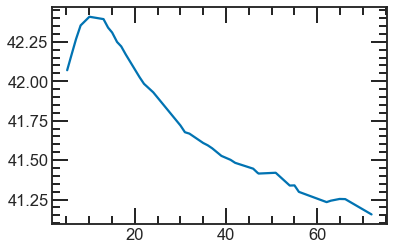

In [6]:
#quick interpolation scheme

f = int.interp1d(DF_1994I['epoch'], DF_1994I['Lbol'])
plt.plot(DF_1994I['epoch'], DF_1994I['Lbol'])

In [7]:
mosfit_BB = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/derived_data/AT2020oi_022421_noSwift_BB_RphotTphot.csv")

In [8]:
mosfit_BB['ph'] = mosfit_BB['time (rest frame MJD from discovery)'] + 1.8

In [9]:
Lbol = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/scripts/superbol/SBO_input/superbol_output_2020oi/logL_bb_2020oi_AUBgVriz.txt", delimiter='\t', header=None, names=['MJD', 'logL', 'logLerr'])
print(np.nanmax(Lbol['logL']))

42.553


(-10.0, 50.0)

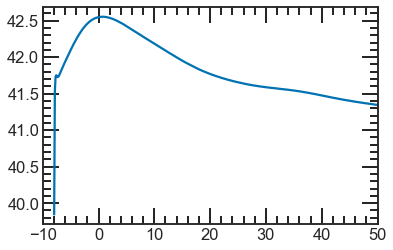

In [10]:
plt.plot(Lbol['MJD']-t0-10, Lbol['logL'])
plt.xlim((-10, 50))

In [11]:
Lbol[np.abs(Lbol['MJD']- 58860.54)<0.1]

,MJD,logL,logLerr
34,58860.56,42.291,0.091


In [12]:
GP_results = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/interpolated_lcs/GPResults_2020oi_withSBO2_Trunc.csv")


(-10.0, 40.0)

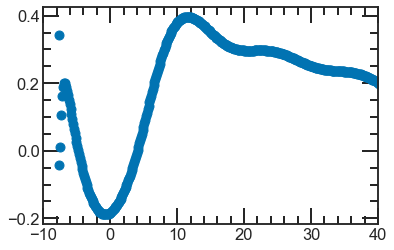

In [13]:
plt.plot(GP_results['MJD']-t0-10, GP_results['V_LC'] - GP_results['rp_LC'], 'o')
plt.xlim((-10, 40))

(0.97, 1.0)

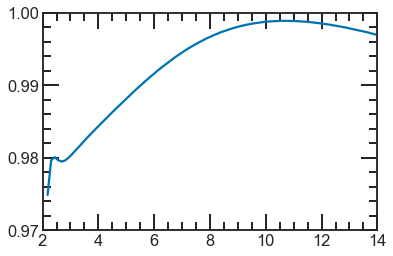

In [14]:
plt.plot(Lbol['MJD'].values[1:]-t0, Lbol['logL'].values[1:]/42.6)
plt.xlim((2, 14))
plt.ylim((0.97, 1.0))

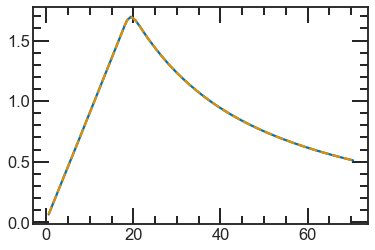

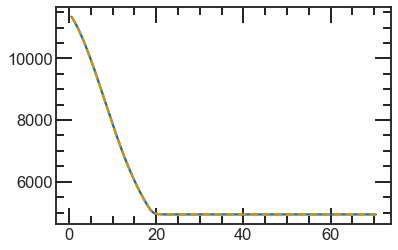

In [15]:
mosfit_BB = mosfit_BB[mosfit_BB['ph'] >0.]
mosfit_BB['R_bb'] = mosfit_BB['Rphot median (cm)']
mosfit_BB['T_bb'] = mosfit_BB['Tphot median (K)']

f_mosfitR = int.interp1d(mosfit_BB['ph'], mosfit_BB['Rphot median (cm)'])
f_mosfitT = int.interp1d(mosfit_BB['ph'], mosfit_BB['Tphot median (K)'])


plt.plot(mosfit_BB['ph'], f_mosfitR(mosfit_BB['ph'])/1.e15)
plt.plot(mosfit_BB['ph'], mosfit_BB['Rphot median (cm)']/1.e15, ls='--')

plt.show()
plt.plot(mosfit_BB['ph'], mosfit_BB['Tphot median (K)'])
plt.plot(mosfit_BB['ph'], f_mosfitT(mosfit_BB['ph']), ls='--')

In [16]:
temp_MOSFITest = f_mosfitT(Lbol['MJD']-t0)
rad_MOSFITest = f_mosfitR(Lbol['MJD']-t0)

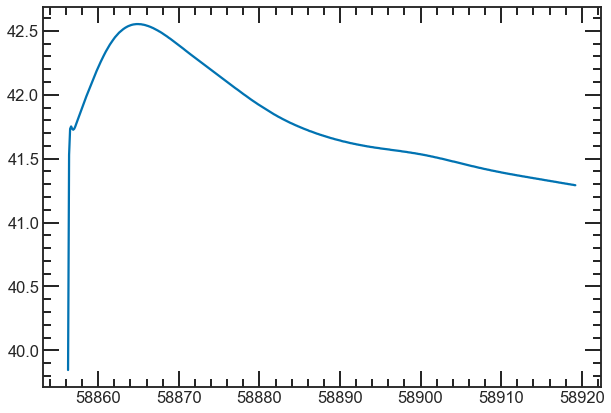

In [17]:
plt.figure(figsize=(10,7))
plt.plot(Lbol['MJD'], Lbol['logL'])

In [18]:
# Define some functions:
def bbody(lam,T,R):
    '''
    Calculate the corresponding blackbody radiance for a set
    of wavelengths given a temperature and radiance.

    Parameters
    ---------------
    lam: Reference wavelengths in Angstroms
    T:   Temperature in Kelvin
    R:   Radius in cm

    Output
    ---------------
    Spectral radiance in units of erg/s/Angstrom

    (calculation and constants checked by Sebastian Gomez)
    '''

    # Planck Constant in cm^2 * g / s
    h = 6.62607E-27
    # Speed of light in cm/s
    c = 2.99792458E10

    # Convert wavelength to cm
    lam_cm = lam * 1E-8

    # Boltzmann Constant in cm^2 * g / s^2 / K
    k_B = 1.38064852E-16

    # Calculate Radiance B_lam, in units of (erg / s) / cm ^ 2 / cm
    exponential = (h * c) / (lam_cm * k_B * T)
    B_lam = ((2 * np.pi * h * c ** 2) / (lam_cm ** 5)) / (np.exp(exponential) - 1)

    # Multiply by the surface area
    A = 4*np.pi*R**2

    # Output radiance in units of (erg / s) / Angstrom
    Radiance = B_lam * A / 1E8

    return Radiance

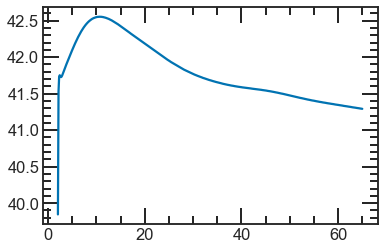

In [19]:
f2020oi = int.interp1d(Lbol['MJD']-t0, Lbol['logL'])
plt.plot(Lbol['MJD']-t0, f2020oi(Lbol['MJD']-t0))

In [20]:
bestFitR_Luca = []
R_test = np.linspace(0, 5, num=10000)
for i in np.arange(len(lucaTime)):
    tempLbol = 10**f(lucaTime[i])
    tempT = lucaTemp[i]
    chi = []
    for R in R_test:
        R *= 1.e15 #to get to cm
        I = quad(bbody, 3000, 10000, args=(tempT,R))
        tempChi = np.abs(tempLbol - I[0])**2/(I[1]**2)
        chi.append(tempChi)
    bestFitR_Luca.append(R_test[chi == np.nanmin(np.array(chi))][0])

NameError: name 'lucaTime' is not defined

In [21]:
time_94I = np.array([8, 10, 16, 19, 20, 24, 38]) #time in days since explosion
T_94I = np.array([9679, 9230, 7690, 6999, 6774, 6383, 6129]) #temperature of the blackbody photosphere in K

bestFitR = []
R_test = np.linspace(0, 5, num=10000)
for i in np.arange(len(time_94I)):
    tempLbol = 10**f(time_94I[i])
    tempT = T_94I[i]
    chi = []
    for R in R_test:
        R *= 1.e15 #to get to cm
        I = quad(bbody, 3000, 10000, args=(tempT,R))
        tempChi = np.abs(tempLbol - I[0])**2/(I[1]**2)
        chi.append(tempChi)
    bestFitR.append(R_test[chi == np.nanmin(np.array(chi))][0])

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


Let's start by importing our required packages.

In [30]:
#t=8 days
#TBB= 9679 K.
#t = 10days
#s TBB= 9230 K
#t = 16 days
#s TBB= 7690 K
#t = 19 days 
#TBB= 6999 K.
# t = 20 days
#TBB= 6774 K 
#t = 24 days
#TBB= 6383 K
# t = 38 days
#TBB= 6129 K
#from https://academic.oup.com/mnras/article/369/4/1939/1094448

time_94I = [8, 10, 16, 19, 20, 24, 38] #time in days since explosion
T_94I = [9679, 9230, 7690, 6999, 6774, 6383, 6129] #temperature of the blackbody photosphere in K

#distance to 1994I -- 8.32 Mpc (27.1 Mly)
d94I = 2.567e25 #centimeters

#Bolometric Luminosity to bolometric flux to temperature and radius
#Flux = L*(4*np.pi*d94I**2)
#fit flux to blackbody 

In [31]:

sns.set_context("poster")

plt.figure(figsize=(10,7))
plt.plot(logL['MJD']-t0, logL['logL'], '--', lw=3, label='New Lbol',c='tab:green')
plt.fill_between(logL['MJD']-t0, logL['logL']-logL['logLerr']/4., logL['logL']+logL['logLerr']/4., color="tab:green", lw=3, alpha=0.5, label='new Lbol', zorder=100)

plt.fill_between(logL_old['MJD']-t0, logL_old['logL']-logL_old['logLerr']/2., logL_old['logL']+logL_old['logLerr']/2., color='tab:orange', lw=3, alpha=0.5, label='old Lbol', zorder=100)

plt.plot(logL_old['MJD']-t0, logL_old['logL'], lw=3, label='Old Lbol', c='tab:orange')
plt.legend()
plt.xlabel(r"Phase from $t_0$")
plt.ylabel(r"log$_{10}$( L$_{bol}$ [erg/s] )")
plt.ylim((41, 42.6))
plt.xlim((0, 10))
#plt.savefig("/Users/alexgagliano/Documents/Research/2020oi/img/SBO_Lbol_Superbol_Zoom.png",dpi=300, bbox_inches='tight')

NameError: name 'logL' is not defined

<Figure size 720x504 with 0 Axes>

And, fitting both the rise and decline: 

A pretty good fit! This will serve as our mean model for this data - we'll now use George to create a gaussian process to fit the data a little more closely. 

In [32]:
BBparams_superbol = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/scripts/superbol/SBO_input/superbol_output_2020oi/BB_params_2020oi_AUBgVriz.txt", delimiter='\t')

In [33]:
#t=8 days
#TBB= 9679 K.
#t = 10days
#s TBB= 9230 K
#t = 16 days
#s TBB= 7690 K
#t = 19 days 
#TBB= 6999 K.
# t = 20 days
#TBB= 6774 K 
#t = 24 days
#TBB= 6383 K
# t = 38 days
#TBB= 6129 K
#from https://academic.oup.com/mnras/article/369/4/1939/1094448

time_94I = [8, 10, 16, 19, 20, 24, 38] #time in days since explosion
T_94I = [9679, 9230, 7690, 6999, 6774, 6383, 6129] #temperature of the blackbody photosphere in K

#These are the results for t0 + 1 day (for the five epochs reported in the plot):
temp_p1day = np.array([5910.43, 7284.93, 6709.5,  6641.6,  6588.17])
temp_p1day_err = np.array([ 648.49, 1026.3,   925.53,  881.25,  883.91])

#and these for t0 + 0.5 days:
temp_pt5day = np.array([6307.54, 7450.15, 6821.14, 6739.71, 6675.67])
temp_pt5day_err = np.array([ 692.06, 1049.57,  940.93,  894.27,  895.65])

In [34]:
BBparams_superbol.columns

Index(['ph', 'T_bb', 'err', 'R_bb', 'err.1', 'L_bb', 'err.2'], dtype='object')

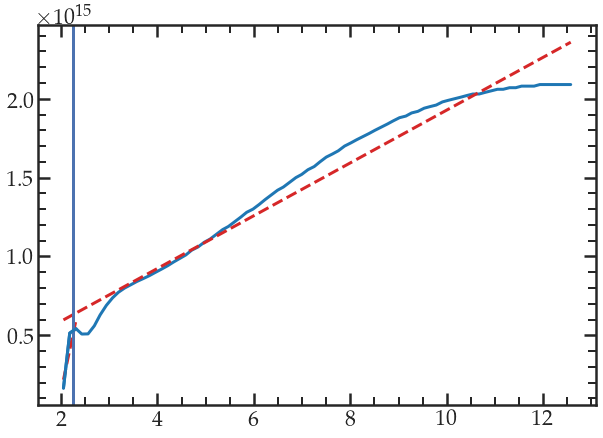

In [35]:
peakMJD = BBparams_superbol.loc[BBparams_superbol['R_bb']==np.nanmax(BBparams_superbol['R_bb']), 'ph'].values[0]
rise = BBparams_superbol.loc[BBparams_superbol['ph'] < peakMJD]
rise = rise[rise['ph'] > t0]

rise_BB = rise[rise['ph'] <= (t0 + 2.4)]

t_sec = (rise['ph'].values)*24*3600
r_cm = rise['R_bb'].values
m, b = np.polyfit(rise['ph'].values, r_cm, 1)
#plt.plot(rise['ph'].values, r_cm)


t_sec = (rise_BB['ph'].values)*24*3600
r_cmBB = rise_BB['R_bb'].values
mBB, bBB = np.polyfit(rise_BB['ph'].values, r_cmBB, 1)

sns.set_context("poster")
plt.figure(figsize=(10,7))
#plt.plot(rise_BB['ph'].values-t0, r_cmBB)
plt.plot(rise['ph'].values-t0, r_cm, c='tab:blue')
plt.plot(rise['ph'].values-t0,  m*rise['ph'].values + b, c='tab:red', ls='--')
plt.plot(rise_BB['ph'].values-t0, mBB*rise_BB['ph'].values + bBB, c='tab:red', ls='--')
plt.axvline(x=2.25)
plt.plot(rise_BB['ph'].values-t0,r_cmBB, c='tab:blue')

In [36]:
0.25*24

6.0

In [37]:
mBB/2.59e+15 #speed of light in cm/day

0.5598455598023326

In [38]:
m/2.59e+15 #cm/day

0.06462405952418403

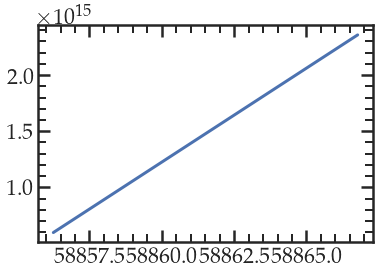

In [39]:
plt.plot(rise['ph'].values, m*rise['ph'].values+b)

In [54]:
lucaFits = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/derived_data/for_Alex_results_temperature.txt", delim_whitespace=True)

In [55]:
#lucaFits['Day'] -= 1.0
lucaFits['radius'] = lucaFits['vexp'] * lucaFits['Day'] * 86400 * 1.e5

In [56]:
#lucaFits['radius_err'] = np.sqrt(lucaFits['vexp_err']**2 + lucaFits['temperature_err']**2)
lucaFits['radius_err'] = np.sqrt((2*lucaFits['radius']*lucaFits['temperature_err']/lucaFits['temperature'])**2 + (0.5*lucaFits['radius']*10**lucaFits['Lbolo_err']/10**lucaFits['Lbolo']))

In [57]:
lucaFits

,Day,MJD,Lbolo,Lbolo_err,vexp,vexp_err,temperature,temperature_err,radius,radius_err
0,3.1,58857.3,41.78,0.08,23500,2000,6797,745,6.294240e+14,1.379788e+14
1,6.4,58892.0,42.18,0.10,23500,2000,7140,940,1.299456e+15,3.421537e+14
2,10.4,58864.6,42.55,0.10,13500,1500,7627,1074,1.213056e+15,3.416342e+14
3,14.4,58868.6,42.45,0.10,10500,1000,6938,957,1.306368e+15,3.603904e+14
4,16.3,58870.5,42.36,0.10,8600,500,6842,908,1.211155e+15,3.214642e+14
5,18.2,58872.4,42.27,0.10,7100,500,6766,907,1.116461e+15,2.993290e+14


In [60]:
lucaFits.loc[lucaFits['MJD']==58892.0, 'radius'] = 8.98e14
lucaFits.loc[lucaFits['MJD']==58892.0, 'radius_err'] = 1.34e14

In [62]:
lucaFits

,Day,MJD,Lbolo,Lbolo_err,vexp,vexp_err,temperature,temperature_err,radius,radius_err
0,3.1,58857.3,41.78,0.08,23500,2000,6797,745,6.294240e+14,1.379788e+14
1,6.4,58892.0,42.18,0.10,23500,2000,7140,940,8.980000e+14,1.340000e+14
2,10.4,58864.6,42.55,0.10,13500,1500,7627,1074,1.213056e+15,3.416342e+14
3,14.4,58868.6,42.45,0.10,10500,1000,6938,957,1.306368e+15,3.603904e+14
4,16.3,58870.5,42.36,0.10,8600,500,6842,908,1.211155e+15,3.214642e+14
5,18.2,58872.4,42.27,0.10,7100,500,6766,907,1.116461e+15,2.993290e+14


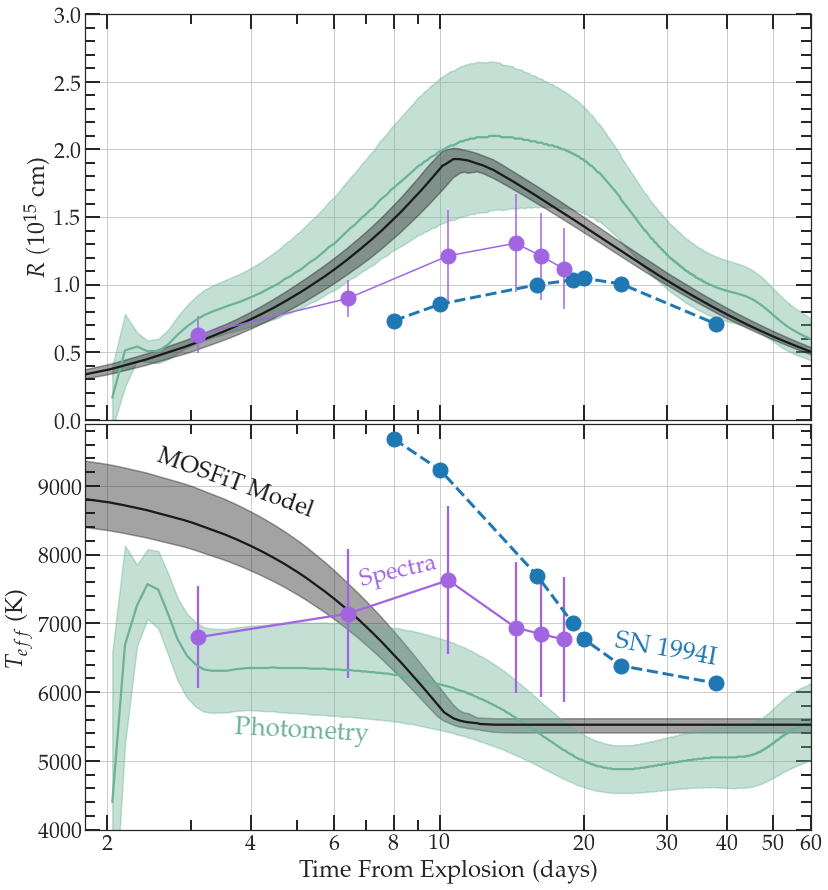

In [61]:

sns.set_context("poster")
sns.set(font_scale=2)
sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

xnew = np.linspace(0, 50)

def t0_to_mjd(x):
    return x + t0

def mjd_to_t0(x):
    return x - t0

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(13,15),sharex=True)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.01)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

label_format = '{:.2f}'

lucaTime = [10.4, 14.4, 16.3, 18.2]
lucaTemp = [6975, 6585, 6681, 6161]
lucaRadius = np.array([1330560000000000.0, 1425600000000000.0, 1248480000000000.0, 1264032000000000.0])

xmax = 60
#ax1.text(4.6, 1., r"$v_{ph}$ = %.2fc"%(m/(3600*24)/2.998e10), color='gray', rotation=53, style='italic')
#ax1.text(4.6, 0.3, r"$v_{ph}$ = %.2fc"%(mBB/(3600*24)/2.998e10), color='gray', rotation=53, style='italic')

ax1.grid(True)
ax2.grid(True)
ax1.set_ylim((0.0, 3.))
ax2.set_xlim((1.8, 60))
ax2.set_ylim((4000, 9900))
ax1.set_xscale("log")

#absMJD = ax1.secondary_xaxis('top', functions=(t0_to_mjd, mjd_to_t0))
#absMJD.set_xlabel('Time (MJD)')

from matplotlib.ticker import FormatStrFormatter
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#absMJD.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

import matplotlib.ticker as mticker

ax1.set_xticks([2, 4, 6, 8, 10, 20, 30, 40, 50, 60])
plt.plot()
#ax1.plot(lucaTime, bestFitR_Luca, 'o-', c='tab:red', ms=15)
#ax1.errorbar(lucaTime, lucaRadius/1.e15, yerr=0.5, fmt='o-', c='#A165E2', ms=15)
ax1.errorbar(lucaFits['Day'], lucaFits['radius']/1.e15, yerr=lucaFits['radius_err']/1.e15, fmt='o-', c='#A165E2', ms=15)

t0 = 58854.2
peak = 58866.1

#ax1.plot(xnew, (m*(xnew)+b)/1.e15, 'k--', alpha=0.5, lw=3)
#ax1.plot(xnew, (mBB*(xnew)+bBB)/1.e15, 'k--', alpha=0.5, lw=3)
ax1.plot(time_94I, bestFitR, 'o--', ms=15, lw=3, c='tab:blue')
ax2.set_xlabel("Time From Explosion (days)")
ax1.set_ylabel(r"$R \ (10^{15}$ cm)");
ax2.set_ylabel(r"$T_{eff}$ (K)");
sns.set_context("talk")
ax1.plot(BBparams_superbol['ph']-t0, BBparams_superbol['R_bb']/1.e15, c='#6CB298')
#ax1.plot(rise['ph'].values-t0, (m*rise['ph'].values+b)/1.e15, ls='--')

#ax1.plot(mosfit_BB['ph'], mosfit_BB['R_bb']/1.e15, c='k', ls=':', lw=3)
ax1.fill_between(BBparams_superbol['ph']-t0, (BBparams_superbol['R_bb']-BBparams_superbol['err.1'])/1.e15, (BBparams_superbol['R_bb']+BBparams_superbol['err.1'])/1.e15, alpha=0.4, color='#6CB298')
ax2.plot(BBparams_superbol['ph']-t0, BBparams_superbol['T_bb'], c='#6CB298')
#ax2.plot(mosfit_BB['ph'], mosfit_BB['T_bb'], c='k', ls=':', lw=3)
#ax2.text(26, 5100, "MOSFiT Model", color='k',fontsize=26, style='italic')
#ax2.errorbar(lucaTime, lucaTemp, yerr=500, fmt='o-', c='#A165E2', ms=15)
ax2.errorbar(lucaFits['Day'], lucaFits['temperature'], yerr=lucaFits['temperature_err'], fmt='o-', c='#A165E2', ms=15)

data = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/derived_data/AT2020oi_clean_050621_noSSuV_constnhhost_minMJD58857_kappa0.07_BB_RphotTphot.csv")
ax1.plot(data['time (rest frame MJD from discovery)']+2, data['Rphot median (cm)']/1.e15, c='k')
ax1.fill_between(data['time (rest frame MJD from discovery)']+2, data['Rphot min (cm)']/1.e15, data['Rphot max (cm)']/1.e15, alpha=0.4, color='k')
ax2.plot(data['time (rest frame MJD from discovery)']+2, data['Tphot median (K)'], c='k')
ax2.fill_between(data['time (rest frame MJD from discovery)']+2, data['Tphot min (K)'], data['Tphot max (K)'], alpha=0.4, color='k')

#ax2.errorbar(lucaFits['Day'], temp_pt5day, c='tab:red', marker='s')
#ax2.errorbar(lucaFits['Day'], temp_p1day, c='tab:red', marker='d')

ax2.fill_between(BBparams_superbol['ph']-t0, BBparams_superbol['T_bb']-BBparams_superbol['err'], BBparams_superbol['T_bb']+BBparams_superbol['err'], alpha=0.4, color='#6CB298')
ax2.text(23, 6400, "SN 1994I", color='tab:blue',rotation=-10,fontsize=26, style='italic')
ax2.text(3.7, 5300, "Photometry", color='#6CB298',fontsize=26, style='italic', rotation=-3)
ax2.text(6.7, 7550, "Spectra", color='#A165E2',fontsize=24, style='italic', rotation=13)
ax2.text(2.5, 8550, "MOSFiT Model", color='k',fontsize=24, style='italic', rotation=-20)

ax2.plot(time_94I, T_94I, 'o--', ms=15, lw=3, c='tab:blue')

plt.savefig("/Users/alexgagliano/Documents/Research/2020oi/img/PhotoFits_SuperbolvSpectra.png",dpi=200, bbox_inches='tight')

In [45]:
BBparams_superbol[np.abs(BBparams_superbol['ph'] - t0 - 11.5) < 0.1]

,ph,T_bb,err,R_bb,err.1,L_bb,err.2
74,58865.63,5980.0,640.0,2.070000e+15,5.580000e+14,3.920000e+42,2.700000e+42
75,58865.75,5970.0,637.0,2.080000e+15,5.580000e+14,3.900000e+42,2.680000e+42


In [198]:
BBparams_superbol[BBparams_superbol['R_bb'] == np.nanmax(BBparams_superbol['R_bb'])]

,ph,T_bb,err,R_bb,err.1,L_bb,err.2
84,58866.89,5840.0,606.0,2.100000e+15,5.510000e+14,3.650000e+42,2.440000e+42
85,58867.02,5830.0,602.0,2.100000e+15,5.500000e+14,3.610000e+42,2.410000e+42
86,58867.15,5810.0,598.0,2.100000e+15,5.480000e+14,3.570000e+42,2.380000e+42
87,58867.27,5800.0,593.0,2.100000e+15,5.460000e+14,3.540000e+42,2.340000e+42
88,58867.40,5780.0,589.0,2.100000e+15,5.440000e+14,3.500000e+42,2.310000e+42
89,58867.53,5770.0,585.0,2.100000e+15,5.420000e+14,3.460000e+42,2.270000e+42


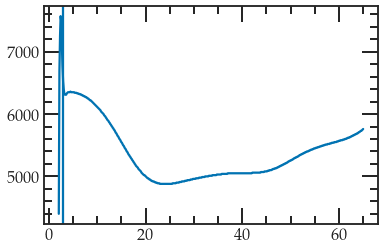

In [189]:
plt.plot(BBparams_superbol['ph']-t0, BBparams_superbol['T_bb'])
plt.axvline(x=3)

Text(0.5, 1.0, '2020oi Blackbody-estimated Temperature')

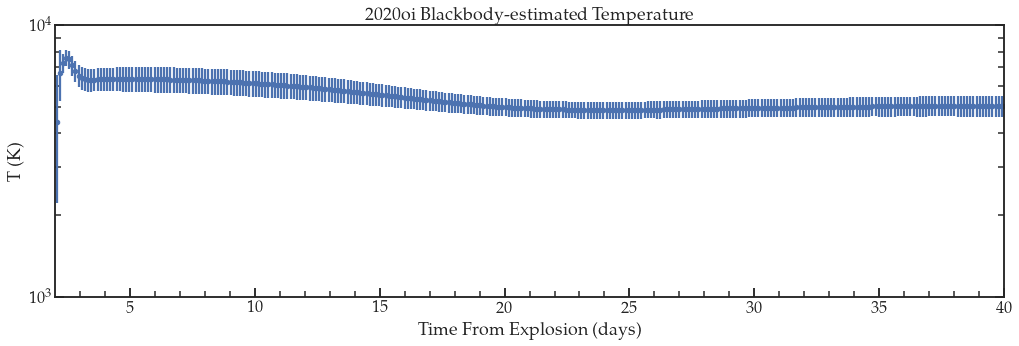

In [211]:
plt.figure(figsize=(17,5))
t0 = 58854.2

plt.errorbar(BBparams_superbol['ph']-t0, BBparams_superbol['T_bb'], yerr=BBparams_superbol['err'], fmt='.', label=r'Superbol');
#plt.plot(BBparams_superbol['ph']-peakTime, BBparams_superbol['T_bb'], '.', label=r'Superbol');
plt.xlabel("Time From Explosion (days)")
plt.ylabel(r"T (K)")
plt.yscale("log")
plt.xlim((2, 40))
plt.ylim((1.e3, 1.e4))
plt.title("2020oi Blackbody-estimated Temperature")

In [70]:
rise = BBparams_superbol[BBparams_superbol['ph']<peakTime]

In [71]:
BBparams_superbol['ph']

0     58856.00
1     58856.57
2     58857.13
3     58857.70
4     58858.26
        ...   
95    58909.74
96    58910.30
97    58910.87
98    58911.43
99    58912.00
Name: ph, Length: 100, dtype: float64

In [73]:
t_sec = (rise['ph'].values -  58856.00)*24*3600
r_cm = rise['R_bb'].values
m, b = np.polyfit(rise['ph'].values-t0, r_cm, 1)

In [866]:
m/(3600*24)/2.998e10

NameError: name 'm' is not defined

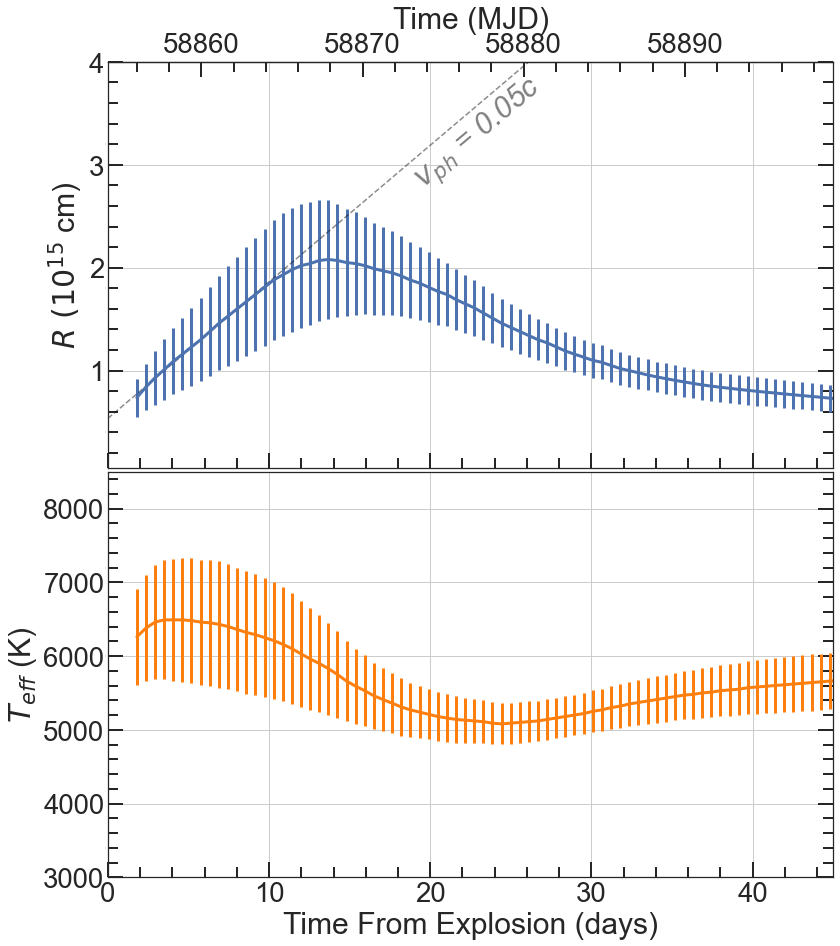

In [589]:
sns.set_context("poster")
sns.set(font_scale=2.5)
sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
#plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

xnew = np.linspace(0, 50)

def t0_to_mjd(x):
    return x + t0

def mjd_to_t0(x):
    return x - t0

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(13,15),sharex=True)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.01)

ax1.errorbar(BBparams_superbol['ph']-t0, BBparams_superbol['R_bb']/1.e15, yerr=BBparams_superbol['err.1']/1.e15, lw=3);
ax2.errorbar(BBparams_superbol['ph']-t0, BBparams_superbol['T_bb'], yerr=BBparams_superbol['err'], lw=3, c='tab:orange');
ax1.plot(xnew, (m*(xnew)+b)/1.e15, 'k--', alpha=0.5)
ax1.text(18.6, 2.8, r"$v_{ph}$ = 0.05c", color='gray', rotation=40, style='italic')
ax1.grid(True)
ax2.grid(True)
ax2.set_xlim((0, 45))
ax2.set_ylim((3000, 8500))
ax1.set_ylim(ymax=4.0)

absMJD = ax1.secondary_xaxis('top', functions=(t0_to_mjd, mjd_to_t0))
absMJD.set_xlabel('Time (MJD)')
    
absMJD.set_xlim((0+t0,45+t0))
#ax1.set_ylim((1.e14/1.e15, 2.e15/1.e15))
ax2.set_xlabel("Time From Explosion (days)")
ax1.set_ylabel(r"$R \ (10^{15}$ cm)");
ax2.set_ylabel(r"$T_{eff}$ (K)");
plt.savefig("/Users/alexgagliano/Documents/Research/2020oi/img/BBody_properties_2020oi_0217.png", bbox_inches='tight',dpi=300)

In [218]:
np.max(BBparams_superbol['R_bb'])

1360000000000000.0

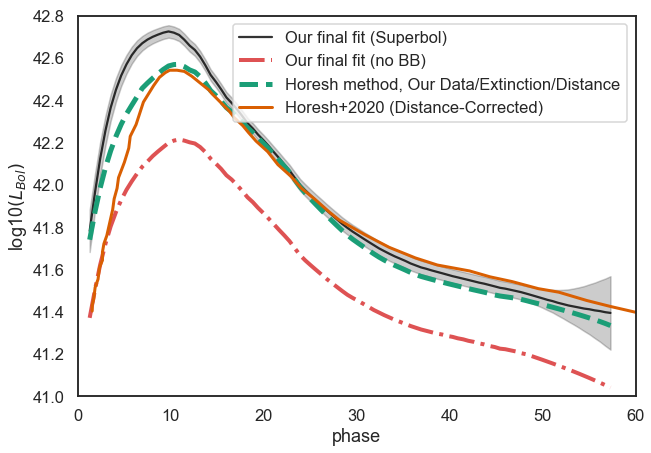

In [208]:
# new ways of estimating the bolometric luminosity, 
# using the bolometric corrections found in 
# https://academic.oup.com/mnras/article/437/4/3848/1011706#equ5
Lbol_20oi_ours = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/bol_2020oi_griz_wErr.txt")
df = pd.read_csv("../data/2020oi_griz.txt")
Mbol_20oi_theirs = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/Digitized_2020oiLbol_OtherPaper.csv", header=None, names=['phase(days)', 'MBol'])

ebv = 0.173

tStart = 58854.7

##Extinction coefficients in A_lam / E(B-V). Uses York Extinction Solver (http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/community/YorkExtinctionSolver/coefficients.cgi)
extco = {'u': 4.786,  'g': 3.587, 'r': 2.471, 'i': 1.798,  'z': 1.403, 'y': 1.228, 'Y': 1.228,
         'U': 4.744,  'B': 4.016, 'V': 3.011, 'R': 2.386, 'G': 2.216, 'I': 1.684, 'J': 0.813, 'H': 0.516,
         'K': 0.337, 'S': 8.795, 'D': 9.270, 'A': 6.432,  'F': 8.054,  'N': 8.969, 'o': 2.185, 'c': 3.111}


# Subtract foreground extinction using input E(B-V) and coefficients from YES
df['gmag'] -= extco['g']*ebv
df['rmag'] -= extco['r']*ebv
df['imag'] -= extco['i']*ebv

#convert to absolute magnitude
d = 1.71e7 # 17.1 Mpc, distance to M100 
#d = 1.4e7 # 14 Mpc, distance used in the other paper

M_g = -5*np.log10(d/10) + df['gmag'].values
M_r = -5*np.log10(d/10) + df['rmag'].values
M_i = -5*np.log10(d/10) + df['imag'].values

col_gr = df['gmag'].values-df['rmag'].values
err_gr = np.sqrt(df['gmagerr']**2 + df['rmagerr']**2)
BCg = 0.054 - 0.195*col_gr - 0.719*col_gr**2

M_bol = M_g + BCg

Fsol = 3.83e33 # erg/s/cm
Msol = 4.77

Fbol_20oi = Fsol * 10**((Msol-M_bol)/2.5)


Mbol_20oi_theirs['MBol'] -= 1.0
Fbol_20oi_theirs = Fsol * 10**((Msol-Mbol_20oi_theirs['MBol'].values)/2.5)

plt.figure(figsize=(10,7))
#plt.plot(df['MJD'], df['gmag'], 'o')
#plt.plot(df['MJD'], df['rmag'], 'o')
#plt.plot(df['MJD'], df['imag'], 'o')
#plt.plot(df['MJD'], df['zmag'], 'o')
sns.lineplot(x=Lbol_20oi_ours['ph']-tStart, y=np.log10(Lbol_20oi_ours['L+BB']), ms=1, alpha=0.8,color='k', label='Our final fit (Superbol)')
sns.lineplot(x=Lbol_20oi_ours['ph']-tStart, y=np.log10(Lbol_20oi_ours['Lobs']), ms=1, alpha=0.8,color='tab:red', ls='-.', label='Our final fit (no BB)', lw=4)
plt.fill_between(Lbol_20oi_ours['ph']-tStart, np.log10(Lbol_20oi_ours['L+BB'])-Lbol_20oi_ours['GP_Err']/2,np.log10(Lbol_20oi_ours['L+BB'])+Lbol_20oi_ours['GP_Err']/2, alpha=0.2,color='k')
plt.plot(df['MJD']-tStart,np.log10(Fbol_20oi), '--', label='Horesh method, Our Data/Extinction/Distance', lw=5)
plt.plot(Mbol_20oi_theirs['phase(days)'], np.log10(Fbol_20oi_theirs*(17.1/14.)**2), lw=3, label='Horesh+2020 (Distance-Corrected)')
plt.xlim((0, 60))
plt.ylim((41, 42.8))
plt.ylabel(r"log10$(L_{Bol})$")
plt.xlabel("phase")
plt.legend()

In [196]:
np.log10(Lbol_20oi_ours['err'])/2

0     20.012653
1     20.086593
2     20.151598
3     20.206650
4     20.251214
        ...    
95    19.879077
96    19.877174
97    19.876024
98    19.875254
99    19.874481
Name: err, Length: 100, dtype: float64

In [193]:
Lbol_20oi_ours

,ph,Lobs,err,L+BB,err.1,GP_Err
0,58856.00,2.350000e+41,1.060000e+40,6.060000e+41,3.470000e+41,0.199788
1,58856.57,3.190000e+41,1.490000e+40,9.190000e+41,5.490000e+41,0.178537
2,58857.13,4.190000e+41,2.010000e+40,1.330000e+42,8.330000e+41,0.158986
3,58857.70,5.270000e+41,2.590000e+40,1.810000e+42,1.200000e+42,0.141193
4,58858.26,6.370000e+41,3.180000e+40,2.320000e+42,1.590000e+42,0.125211
...,...,...,...,...,...,...
95,58909.74,1.220000e+41,5.730000e+39,2.580000e+41,1.300000e+41,0.236778
96,58910.30,1.190000e+41,5.680000e+39,2.550000e+41,1.300000e+41,0.262202
97,58910.87,1.160000e+41,5.650000e+39,2.530000e+41,1.290000e+41,0.289160
98,58911.43,1.130000e+41,5.630000e+39,2.500000e+41,1.290000e+41,0.317571


In [180]:
Fbol_20oi_ourVals = np.log10(Fbol_20oi)

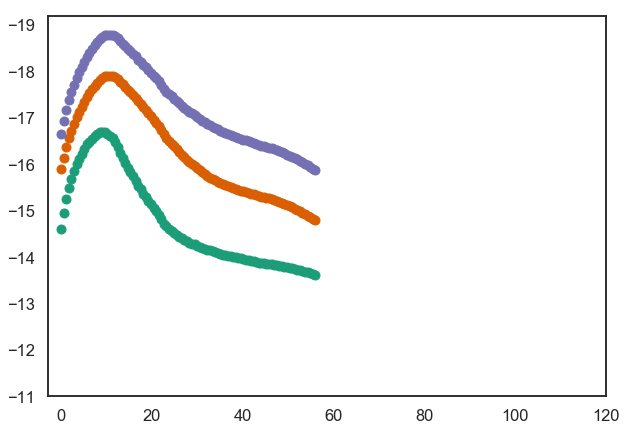

In [127]:
plt.figure(figsize=(10,7))
plt.plot(df['MJD']-df['MJD'].values[0], M_g, 'o')
plt.plot(df['MJD']-df['MJD'].values[0], M_r-1, 'o')
plt.plot(df['MJD']-df['MJD'].values[0], M_i-2, 'o')
plt.xlim((-3, 120))
plt.ylim((-19.2, -11))
plt.gca().invert_yaxis()

In [305]:
#distance modulus uncertainty
d = 1.71e7 #mpc
dL = 1.4e7 #mpc
dH = 2.0e7 #mpc
print(5*np.log10(d/10)) #pc
lowbar = 5*np.log10(d/10) - 5*np.log10(dL/10) #pc
highbar = 5*np.log10(dH/10) - 5*np.log10(d/10) #pc

31.16498055196077


In [307]:
print(lowbar)
print(highbar)

0.43434037356957944
0.34016942635913594
